# Import libs

In [1]:
import statistics
import numpy as np
import pandas as pd
from math import sqrt
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os as os
from scipy.optimize import curve_fit
from scipy.stats import iqr

In [2]:
#move up in directory
os.chdir('../')

In [3]:
os.getcwd()

'C:\\Users\\deniz\\Desktop\\PhD\\p3_volatility_adaptation'

# Import data

In [4]:
stanfit_0_05 = np.load('data/intermediate_data/modeling/modeling_fits/stanfit_rnn_data_train_sd_0_05.npy')
stanfit_0_1 = np.load('data/intermediate_data/modeling/modeling_fits/stanfit_rnn_data_train_sd_0_1.npy')
stanfit_met = np.load('data/intermediate_data/modeling/modeling_fits/stanfit_rnn_data_train_sd_met.npy')

# Plot

### Confidece interval function

In [5]:
def plot_confidence_interval(x, values, color, ax, z=1.96, horizontal_line_width=0.005):
    mean = np.nanmean(values)
    stdev = np.nanstd(values)
    confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    ax.plot([x, x], [top, bottom], color=color, alpha=1, lw=0.5)
    ax.plot([left, right], [top, top], color=color, alpha=1, lw=0.5)
    ax.plot([left, right], [bottom, bottom], color=color, alpha=1, lw=0.5)
    ax.plot(x, mean, 'o', color=color, markersize = 3)

    return mean, confidence_interval

### Exponential decay function

In [6]:
def exp_fit(x, y0, a, k):
    y = (y0-a) * np.exp(-k * x) + a
    return y

### Curve fit


In [7]:
x = np.around(np.linspace(0.02,0.3,15), decimals=2)
df_list = [stanfit_0_05, stanfit_0_1, stanfit_met]
param_bounds=([0,0,0],[1,1,np.inf])
y_alpha = []
y_beta = []
for i, df in enumerate(df_list):
    
    df = np.mean(df, axis = (1,3))
    alpha = df[0]
    beta = df[1]
    
    fit_alpha = curve_fit(exp_fit, x, alpha ,maxfev = 6000, bounds = param_bounds)
    
    y_alpha.append(exp_fit(x, y0= fit_alpha[0][0], a = fit_alpha[0][1], k = fit_alpha[0][2]))
    
    fit_beta = curve_fit(exp_fit, x, beta, maxfev = 6000)
    
    y_beta.append(exp_fit(x, y0= fit_beta[0][0], a = fit_beta[0][1], k = fit_beta[0][2]))

    #y_switch.append(fit_switch[0][0] * np.exp(-fit_switch[0][1] * x) + fit_switch[0][2])
    
    
    print('START')
    print('Train SD: {}'.format(i))
    print('Alpha')
    print('intercept y0 = {}'.format(fit_alpha[0][0]))
    print('asymptote a = {}'.format(fit_alpha[0][1]))
    print('decay rate k = {}'.format(fit_alpha[0][2]))
    print('Beta')
    print('intercept y0 = {}'.format(fit_beta[0][0]))
    print('asymptote a = {}'.format(fit_beta[0][1]))
    print('decay rate k = {}'.format(fit_beta[0][2]))
    print('END')

START
Train SD: 0
Alpha
intercept y0 = 0.26790879168603987
asymptote a = 5.425219514293222e-05
decay rate k = 0.009754587621803599
Beta
intercept y0 = 116.10632878491333
asymptote a = 13.415630263554231
decay rate k = 37.25902080688797
END
START
Train SD: 1
Alpha
intercept y0 = 0.21055053956222414
asymptote a = 0.49238450541514095
decay rate k = 28.114390940899263
Beta
intercept y0 = 55.66066701732998
asymptote a = 10.987477661186292
decay rate k = 28.537482560007366
END
START
Train SD: 2
Alpha
intercept y0 = 0.11501222660577122
asymptote a = 0.5111205186422478
decay rate k = 23.23362358722839
Beta
intercept y0 = 84.33273436298222
asymptote a = 9.991747499053403
decay rate k = 36.27650911276664
END


### Draw the plot

In [19]:
colors = ['#9658EF', '#C16FAC', '#FF914D']
labels = ['Low volatility', 'Medium volatility', 'Meta-volatility']
#ylabels = [r'Mean $\alpha$-value',r'Mean $\beta$-value']
ylabels = ['Mean Learning Rate','Mean Inverse Temperature']

my_x_label = 'Volatility'


In [20]:
# mean bayesian predictions
x = np.arange(0,15)

y_alpha[0] = exp_fit(x, y0=0.27, a=0.27, k=0.80)
y_alpha[1] = exp_fit(x, y0=0.33, a=0.49, k=0.59)
y_alpha[2] = exp_fit(x, y0=0.26, a=0.51, k=0.48)

In [21]:
y_beta[0] = exp_fit(x, y0=62.16, a=13.41, k=0.75)
y_beta[1] = exp_fit(x, y0=36.25, a=11.00, k=0.57)
y_beta[2] = exp_fit(x, y0=45.98, a=10.00, k=0.73)

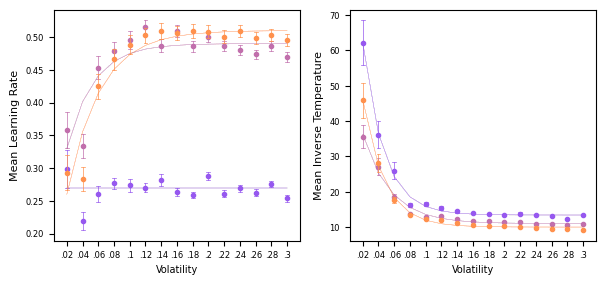

In [22]:
x = np.around(np.linspace(0.02,0.3,15), decimals=2)

array_list = [stanfit_0_05, stanfit_0_1, stanfit_met]
test_sds = np.around(np.linspace(0.02,0.3,15), decimals=2)
my_labels =  ['.02', '.04', '.06', '.08', '.1', '.12', '.14', '.16', '.18', '.2', '.22', '.24', '.26', '.28', '.3']

fig, axs = plt.subplots(1,2, figsize=(7,3))

custom_lines = [Line2D([0], [0], marker='o', color=colors[0], label=labels[0]),
                Line2D([0], [0], marker='o', color=colors[1], label=labels[1]),
                Line2D([0], [0], marker='o', color=colors[2], label=labels[2])]

for ax in range(2):
    for train_sd in range(3):
        for test_sd in test_sds:
            plot_confidence_interval(x=test_sd, 
                                     values=array_list[train_sd][ax,:,int(test_sd*50-1),:].flatten(),
                                     color=colors[train_sd],
                                     ax=axs[ax],)
            
            my_ys = [y_alpha, y_beta]
            axs[ax].plot(x, my_ys[ax][train_sd], color=colors[train_sd], lw=0.25, alpha = 0.1)
            axs[ax].tick_params(labelsize=5)
            
            
    axs[ax].legend(handles=custom_lines)
    axs[ax].set_xticks(np.around(np.linspace(0.02,0.3,15), decimals=2))
    axs[ax].set_ylabel(ylabels[ax], fontsize=7)
    axs[ax].tick_params(labelsize=6)
    
    axs[ax].legend(handles=custom_lines, frameon=False, prop={'size': 8})
    axs[ax].set_xticks(test_sds, labels = my_labels)
    axs[ax].set_ylabel(ylabels[ax], fontsize=8)

    
axs[0].set_xlabel(my_x_label, fontsize=7)
axs[1].set_xlabel(my_x_label, fontsize=7)
axs[1].get_legend().remove()
axs[0].get_legend().remove()


# plt.setp(axs[0].get_xticklabels(), visible=False)
# plt.setp(axs[1].get_xticklabels(), visible=False)


#plt.show()
plt.savefig('plots/alpha_beta_plot.svg', dpi = 300, bbox_inches='tight')

# Barplots

In [23]:
DV = [y_alpha, y_beta]
x = ['Low', 'Medium', 'Meta']

In [24]:
def get_mean_confidence_interval(values, z=1.96):
    mean = np.nanmean(values)
    stdev = np.nanstd(values)
    confidence_interval = z * stdev / sqrt(len(values))
    
    return mean, confidence_interval

In [25]:
y = np.zeros([2,3])
c = np.zeros([2,3])

for i,_ in enumerate(array_list):
    for j, dv in enumerate(DV):
        y[j,i], c[j,i] = get_mean_confidence_interval(values =dv[i])

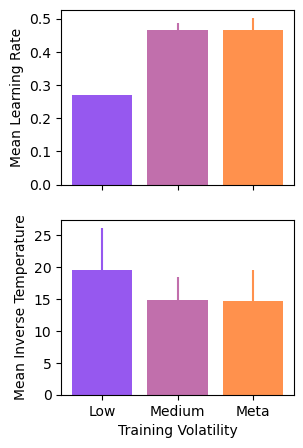

In [26]:
fig, axs = plt.subplots(2,1, figsize=(3,5))

axs[0].bar(x, y[0], color=colors)
axs[0].set_ylabel('Mean Learning Rate')
axs[0].set_xlabel('')
axs[0].errorbar(x, y[0], yerr=c[0], fmt="none", ecolor = colors)
plt.setp(axs[0].get_xticklabels(), visible=False)

axs[1].bar(x, y[1], color=colors)
axs[1].set_ylabel('Mean Inverse Temperature')
axs[1].set_xlabel('Training Volatility')
axs[1].errorbar(x, y[1], yerr=c[1], fmt="none", ecolor = colors)

#plt.show()
plt.savefig('plots/alpha_beta_barplot.png', dpi = 300, bbox_inches='tight')

In [27]:
c[0]

array([2.80925185e-17, 2.20070452e-02, 3.52195999e-02])

In [55]:
# save files for jasp

alpha = []
beta = []
grp = []
id = []
test_sd = []


for i,tsd in enumerate(x):
    alpha.append(np.mean(array_list[i][0], axis = 0))
    beta.append(np.mean(array_list[i][1], axis = 0))
    grp.append([tsd]*(15*30))
    id.append([np.arange(0,30)]*15)
    test_sd.append([[i]*30 for i in test_sds])

In [56]:
df = pd.DataFrame({'alpha':np.array(alpha).flatten(), 'beta':np.array(beta).flatten(), 'grp':np.array(grp).flatten(),
                  'id':np.array(id).flatten(), 'test_sd': np.array(test_sd).flatten()})
df.to_csv('data/intermediate_data/alpha_beta_barplot_data.csv')

In [63]:
# wide format
df1 = df.pivot(index = ['grp', 'id'], columns = 'test_sd', values = ['alpha']).reset_index()
df1.to_csv('data/intermediate_data/alpha_all_levels_wide.csv')

In [64]:
# wide format
df1 = df.pivot(index = ['grp', 'id'], columns = 'test_sd', values = ['beta']).reset_index()
df1.to_csv('data/intermediate_data/beta_all_levels_wide.csv')